In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import scipy
import pyDOE

import torch
import torch.nn as nn

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,  
        hidden_size, 
        output_size, 
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                (f'hidden_{i}', torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append((f'activation_{i}', act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self, A=1.0, B=1.0, C=1.0):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=100,
            output_size=1,
            depth=8,
            act=torch.nn.Tanh
        ).to(device)
        
        # 간격
        self.h = 0.1
        self.k = 0.1
        # (x,y) 좌표점
        x = torch.arange(-np.pi, np.pi + self.h, self.h)
        y = torch.arange(-np.pi, np.pi + self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
        
        # u = f(x,y)=A*sin(B*x)*sin(C*y)
        self.A = torch.tensor([A,])
        self.B = torch.tensor([B,])
        self.C = torch.tensor([C,])
        
        # Boundary Conditions
        # 경계점은 mesh grid로 Data points를 생성
        bc1 = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T 
        bc2 = torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2]) # X_train : Data BCs
        
        f_bc1 = torch.zeros(len(bc1))
        f_bc2 = torch.zeros(len(bc2))
        self.f_train = torch.cat([f_bc1, f_bc2]) # f_train : PDE BCs
        self.f_train = self.f_train.unsqueeze(1)
        
        # Domain Data points는 Latin Hypercube Sampling을 통해 생성
        sample_data = pyDOE.lhs(2, samples=3000)
        sample_data -= 0.5
        sample_data *= 2 * np.pi
        x = torch.tensor(sample_data.T[0], dtype=torch.float)
        y = torch.tensor(sample_data.T[1], dtype=torch.float)
        self.X = torch.cat([x, y]).reshape(2,-1).T
        self.f_true = self.func(x,y)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.f_train = self.f_train.to(device)
        self.f_true = self.f_true.to(device)
        self.X.requires_grad = True
        
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=5,
            tolerance_grad=1e-13, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.00001)
        self.Domain_loss_hist = []
        self.BC_loss_hist = []
        self.pde_loss_hist = []
        self.total_loss_hist = []
        # self.print_model_state()
        
        self.A = self.A.to(device)
        self.B = self.B.to(device)
        self.C = self.C.to(device)
        
    # this won't use
    def func(self, x,y):
        return self.A*torch.sin(self.B*x)*torch.sin(self.C*y)
    
    def print_model_state(self):
        print("Model's state_dict:")
        for param_tensor in self.model.state_dict():
            print(param_tensor, "\t", self.model.state_dict()[param_tensor].size())
            
    def loss_func(self):
        
        # 초기화
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        # Boundary Conditions
        f_pred = self.model(self.X_train)
        loss_BC = self.criterion(f_pred, self.f_train)
        u = self.model(self.X)
        loss_Domain = self.criterion(u.squeeze(), self.f_true)
        
        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
        du_dXX = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dxx = du_dXX[:,0]
        du_dyy = du_dXX[:,1]
        
        # u = f(x,y)=A*sin(B*x)*sin(C*y)
        # fxx + fyy + A*(B^2+C^2)*f = 0
        loss_pde = self.criterion( du_dxx + du_dyy , -self.A*(self.B*self.B+self.C*self.C)*u.squeeze() )

        loss = loss_pde + loss_BC + loss_Domain
        loss.backward()
        if self.iter % 100 == 0:

            print(f"it :{self.iter:04d}, BC Loss :{loss_BC.item():.4e},\t Domain Loss:{loss_Domain.item():.4e},\t PDE Loss :{loss_pde.item():.4e},\t Total Loss :{loss.item()}")
            self.total_loss_hist.append(loss.item())
            self.pde_loss_hist.append(loss_pde.item())
            self.BC_loss_hist.append(loss_BC.item())
            self.Domain_loss_hist.append(loss_Domain.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        print("train with Adam optimizer")
        for i in range(5000):
            self.adam.step(self.loss_func)
        print("train with L-BFGs")
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

### 111 model without data, inference

net_withoutdata_111 testdata_111
Test MSE Loss :  0.40397950668394544


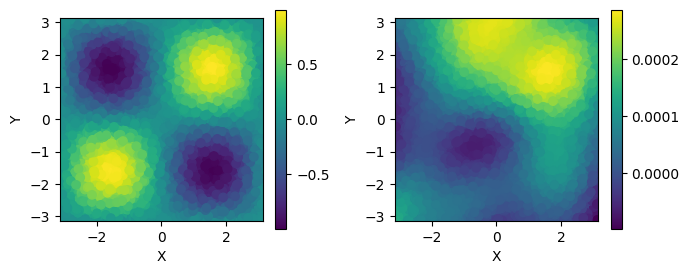

net_withoutdata_111 testdata_221
Test MSE Loss :  0.8133278159169167


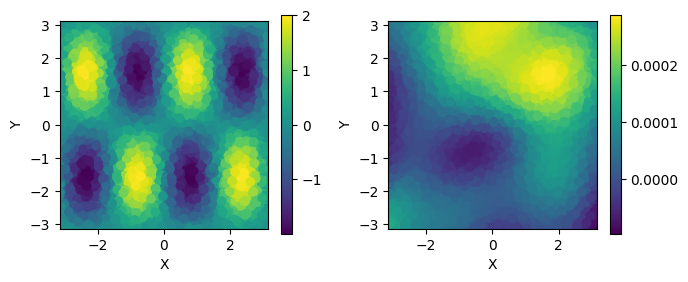

net_withoutdata_111 testdata_212
Test MSE Loss :  0.8104467856706123


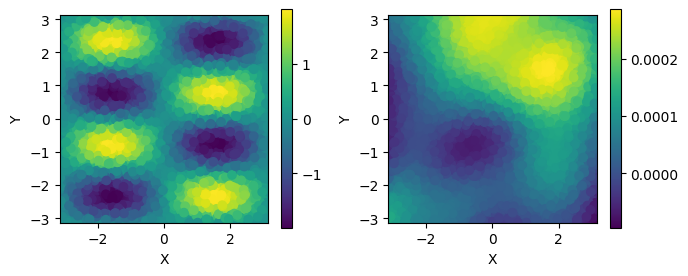

net_withoutdata_111 testdata_122
Test MSE Loss :  0.404226255771965


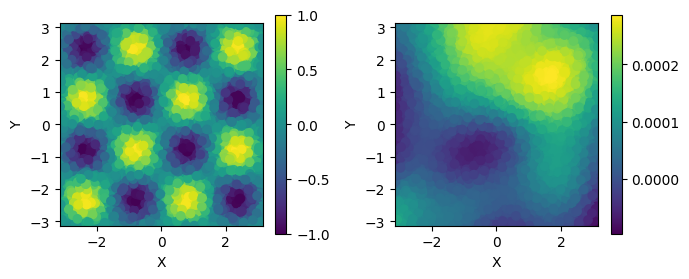

net_withoutdata_111 testdata_311
Test MSE Loss :  1.2198869062020228


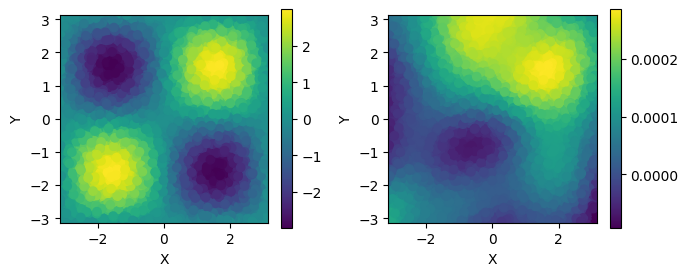

net_withoutdata_111 testdata_131
Test MSE Loss :  0.4061355338963793


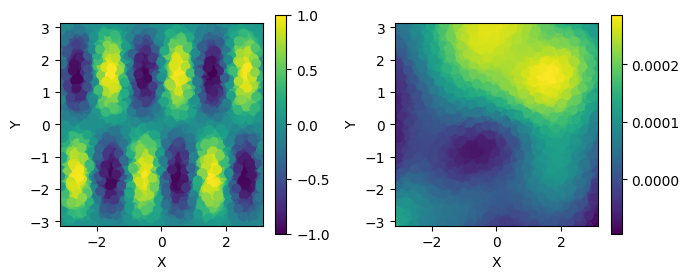

net_withoutdata_111 testdata_113
Test MSE Loss :  0.40551637019732456


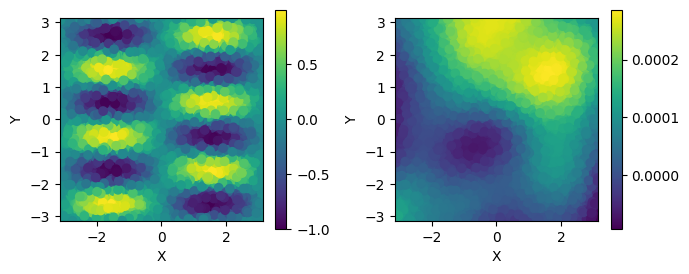

In [30]:
model_name = "model_1_1_1"

net = Net(A=1,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_111")
test_inference(net, "./data/testdata_1_1_1.npy")

net = Net(A=2,B=2,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_221")
test_inference(net, "./data/testdata_2_2_1.npy")

net = Net(A=2,B=1,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_212")
test_inference(net, "./data/testdata_2_1_2.npy")

net = Net(A=1,B=2,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_122")
test_inference(net, "./data/testdata_1_2_2.npy")

net = Net(A=3,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_311")
test_inference(net, "./data/testdata_3_1_1.npy")

net = Net(A=1,B=3,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_131")
test_inference(net, "./data/testdata_1_3_1.npy")

net = Net(A=1,B=1,C=3)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_withoutdata_111", "testdata_113")
test_inference(net, "./data/testdata_1_1_3.npy")

### 111 model, inference

net_data_111 testdata_111
Test MSE Loss :  0.3392716071146843


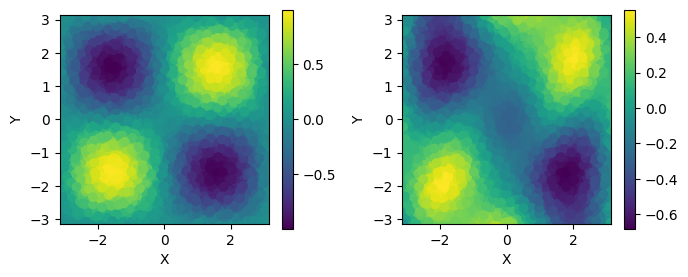

net_data_111 testdata_221
Test MSE Loss :  0.7911882983921226


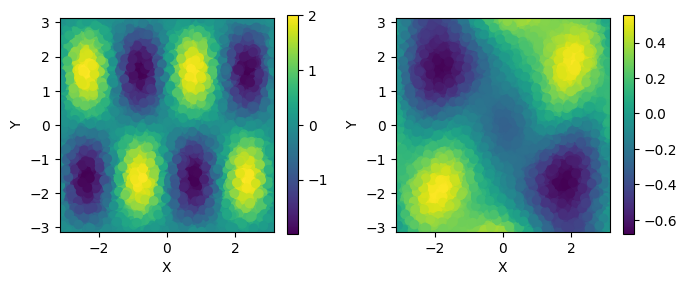

net_data_111 testdata_212
Test MSE Loss :  0.7814269890250047


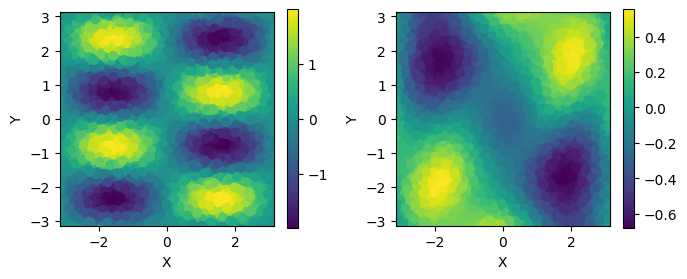

net_data_111 testdata_122
Test MSE Loss :  0.4190052750562574


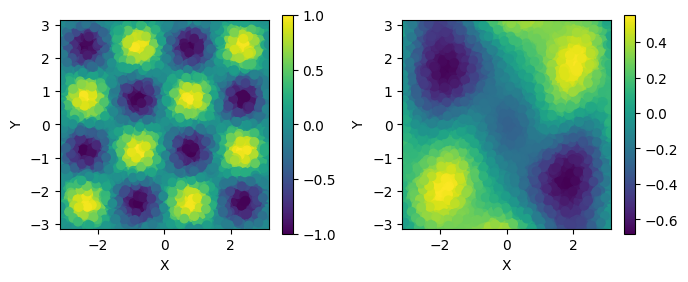

net_data_111 testdata_311
Test MSE Loss :  1.1921528065530265


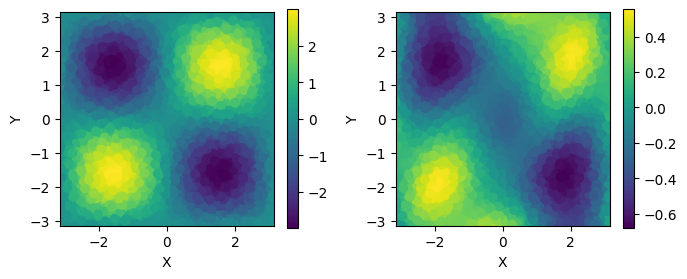

net_data_111 testdata_131
Test MSE Loss :  0.390373911184173


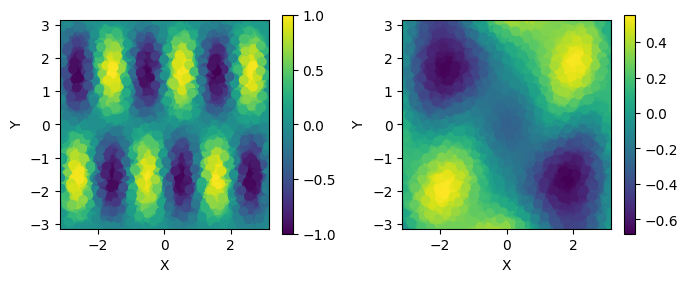

net_data_111 testdata_113
Test MSE Loss :  0.37557323615721117


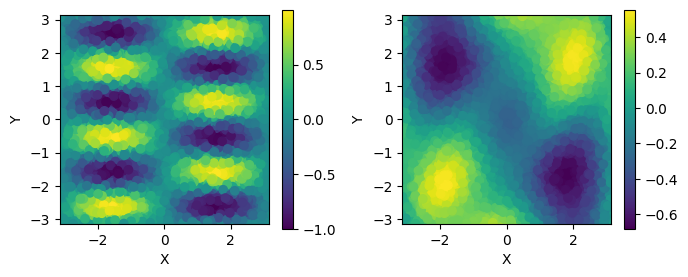

In [32]:
model_name = "model_withdata_1_1_1"

net = Net(A=1,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_111")
test_inference(net, "./data/testdata_1_1_1.npy")

net = Net(A=2,B=2,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_221")
test_inference(net, "./data/testdata_2_2_1.npy")

net = Net(A=2,B=1,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_212")
test_inference(net, "./data/testdata_2_1_2.npy")

net = Net(A=1,B=2,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_122")
test_inference(net, "./data/testdata_1_2_2.npy")

net = Net(A=3,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_311")
test_inference(net, "./data/testdata_3_1_1.npy")

net = Net(A=1,B=3,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_131")
test_inference(net, "./data/testdata_1_3_1.npy")

net = Net(A=1,B=1,C=3)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_111", "testdata_113")
test_inference(net, "./data/testdata_1_1_3.npy")

### 311 model, inference

net_data_311 testdata_111
Test MSE Loss :  0.4209267243008259


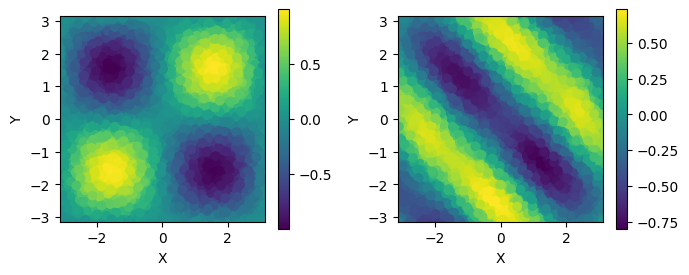

net_data_311 testdata_221
Test MSE Loss :  0.7974566761115491


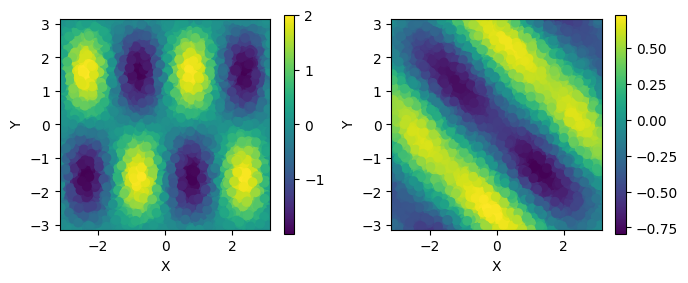

net_data_311 testdata_212
Test MSE Loss :  0.7923506873791962


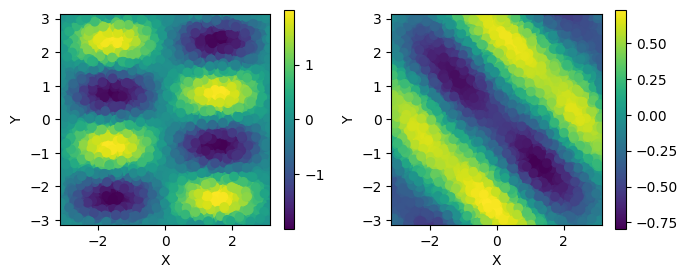

net_data_311 testdata_122
Test MSE Loss :  0.438162339988498


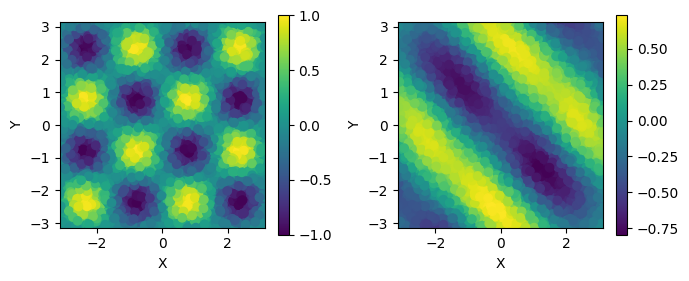

net_data_311 testdata_311
Test MSE Loss :  1.2042743374867229


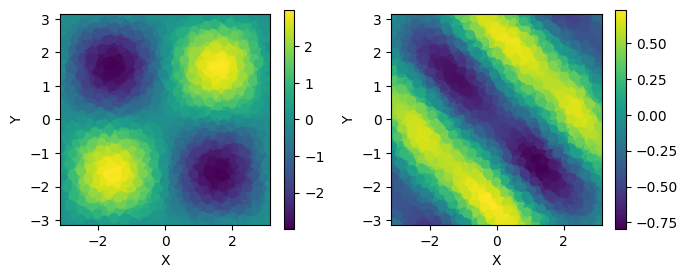

net_data_311 testdata_131
Test MSE Loss :  0.43164089846768383


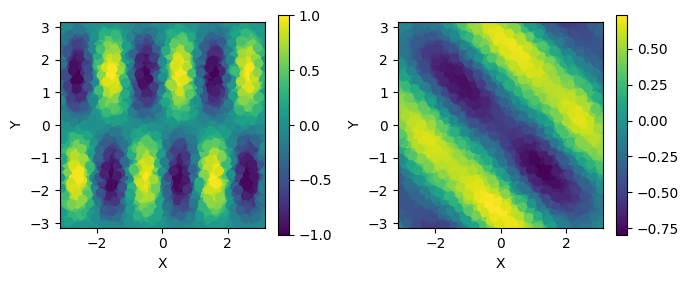

net_data_311 testdata_113
Test MSE Loss :  0.4273226342631986


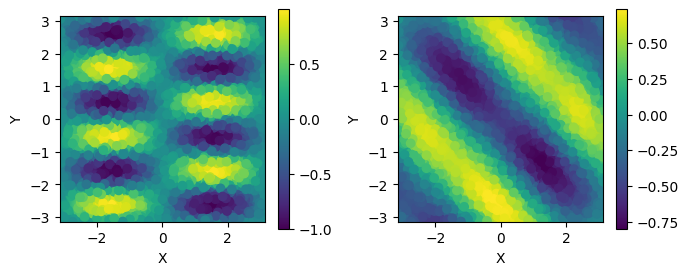

In [33]:
model_name = "model_withdata_3_1_1"

net = Net(A=1,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_111")
test_inference(net, "./data/testdata_1_1_1.npy")

net = Net(A=2,B=2,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_221")
test_inference(net, "./data/testdata_2_2_1.npy")

net = Net(A=2,B=1,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_212")
test_inference(net, "./data/testdata_2_1_2.npy")

net = Net(A=1,B=2,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_122")
test_inference(net, "./data/testdata_1_2_2.npy")

net = Net(A=3,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_311")
test_inference(net, "./data/testdata_3_1_1.npy")

net = Net(A=1,B=3,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_131")
test_inference(net, "./data/testdata_1_3_1.npy")

net = Net(A=1,B=1,C=3)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_311", "testdata_113")
test_inference(net, "./data/testdata_1_1_3.npy")

### 131 model, inference

net_data_131 testdata_111
Test MSE Loss :  0.4039574998916626


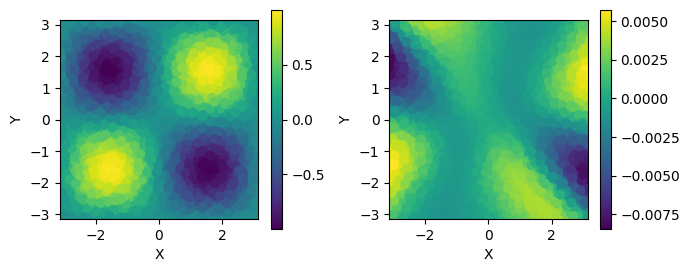

net_data_131 testdata_221
Test MSE Loss :  0.8133145772756968


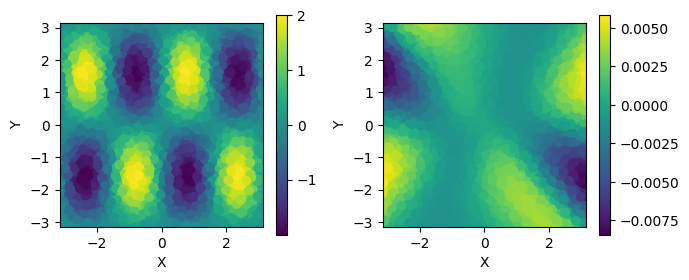

net_data_131 testdata_212
Test MSE Loss :  0.8104298773929755


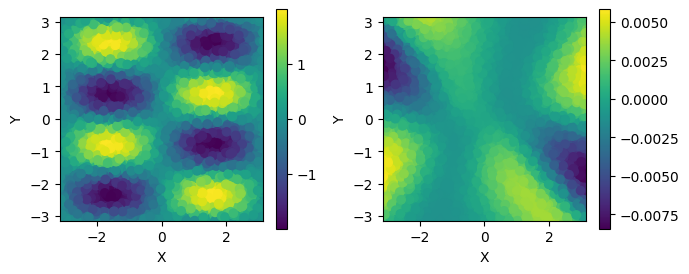

net_data_131 testdata_122
Test MSE Loss :  0.4042035924756736


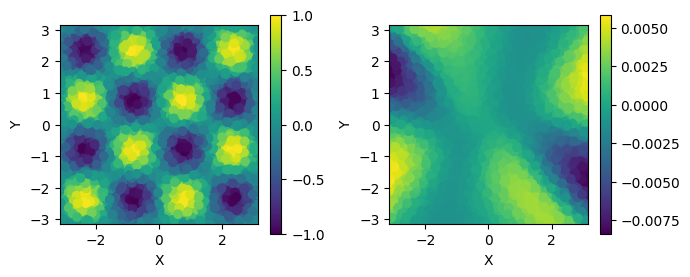

net_data_131 testdata_311
Test MSE Loss :  1.2198783905771973


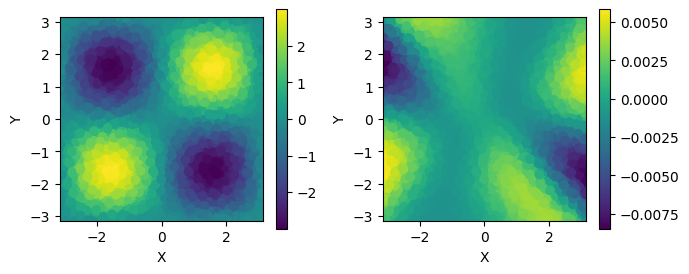

net_data_131 testdata_131
Test MSE Loss :  0.4061173888226546


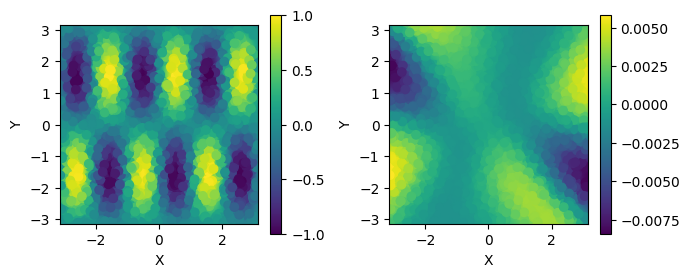

net_data_131 testdata_113
Test MSE Loss :  0.4054905471185701


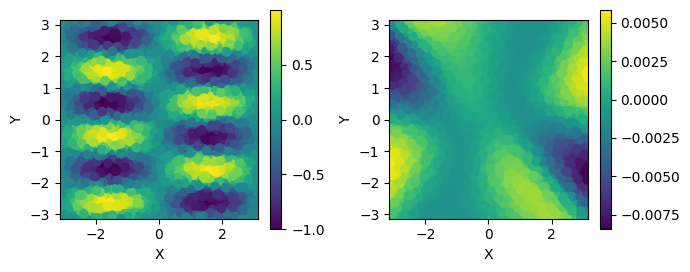

In [34]:
model_name = "model_withdata_1_3_1"

net = Net(A=1,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_111")
test_inference(net, "./data/testdata_1_1_1.npy")

net = Net(A=2,B=2,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_221")
test_inference(net, "./data/testdata_2_2_1.npy")

net = Net(A=2,B=1,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_212")
test_inference(net, "./data/testdata_2_1_2.npy")

net = Net(A=1,B=2,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_122")
test_inference(net, "./data/testdata_1_2_2.npy")

net = Net(A=3,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_311")
test_inference(net, "./data/testdata_3_1_1.npy")

net = Net(A=1,B=3,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_131")
test_inference(net, "./data/testdata_1_3_1.npy")

net = Net(A=1,B=1,C=3)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_131", "testdata_113")
test_inference(net, "./data/testdata_1_1_3.npy")

### 113 model, inference

net_data_113 testdata_111
Test MSE Loss :  0.3974962560917603


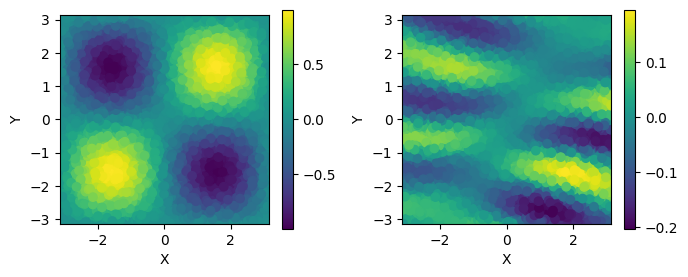

net_data_113 testdata_221
Test MSE Loss :  0.8083375866128478


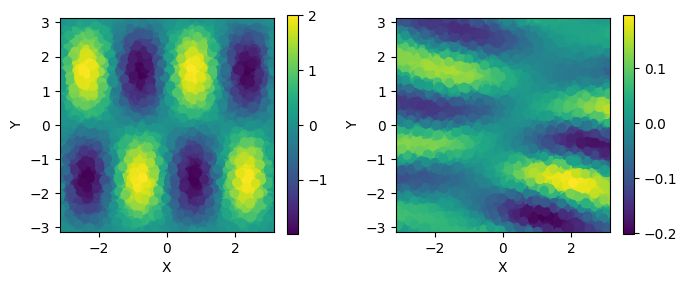

net_data_113 testdata_212
Test MSE Loss :  0.8058274331780655


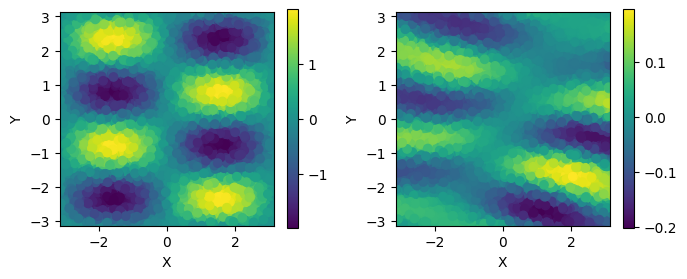

net_data_113 testdata_122
Test MSE Loss :  0.39968989049319


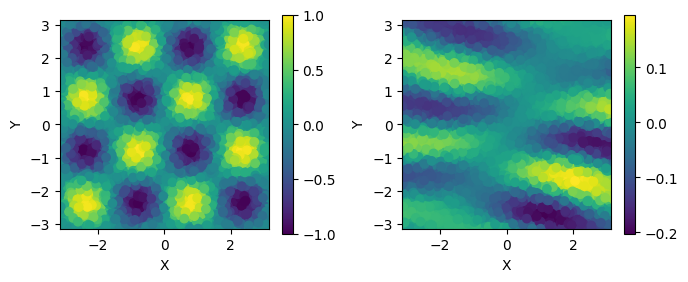

net_data_113 testdata_311
Test MSE Loss :  1.2154793018869097


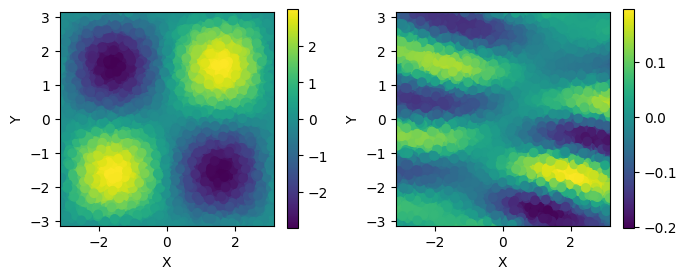

net_data_113 testdata_131
Test MSE Loss :  0.400821747420024


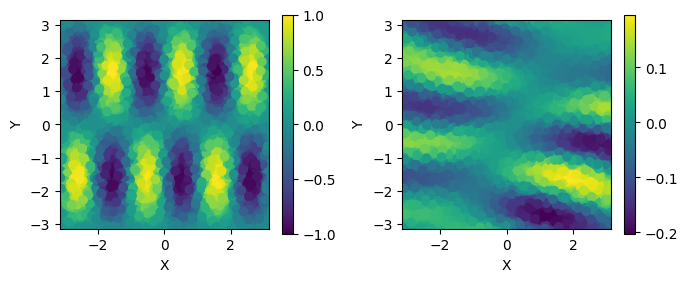

net_data_113 testdata_113
Test MSE Loss :  0.39993436007517374


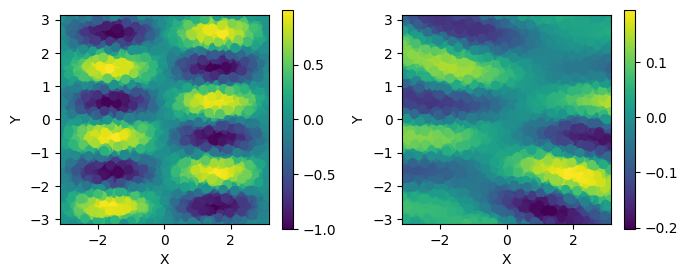

In [35]:
model_name = "model_withdata_1_1_3"

net = Net(A=1,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_111")
test_inference(net, "./data/testdata_1_1_1.npy")

net = Net(A=2,B=2,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_221")
test_inference(net, "./data/testdata_2_2_1.npy")

net = Net(A=2,B=1,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_212")
test_inference(net, "./data/testdata_2_1_2.npy")

net = Net(A=1,B=2,C=2)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_122")
test_inference(net, "./data/testdata_1_2_2.npy")

net = Net(A=3,B=1,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_311")
test_inference(net, "./data/testdata_3_1_1.npy")

net = Net(A=1,B=3,C=1)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_131")
test_inference(net, "./data/testdata_1_3_1.npy")

net = Net(A=1,B=1,C=3)
net.model.load_state_dict(torch.load(f"./data/{model_name}.pt"))
print("net_data_113", "testdata_113")
test_inference(net, "./data/testdata_1_1_3.npy")

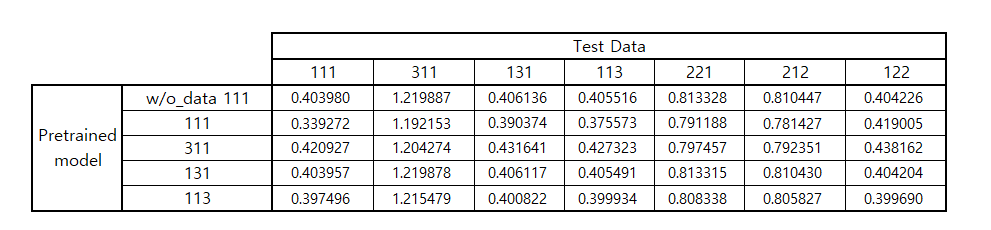